## Transform data into larger chunks of around 500 tokens
This assumes that the dataset is ordered sequentially. If this is not the case, then this part should be skipped

In [43]:
import pandas as pd
import openai

openai.api_key = '<<OPENAI_API_KEY>>'  # beta.openai.com/login/

hf = pd.read_json('data/huggingface-qa.jsonl', lines=True)
pt = pd.read_json('data/pytorch-qa.jsonl', lines=True)
tf = pd.read_json('data/tensorflow-qa.jsonl', lines=True)
sl = pd.read_json('data/streamlit-qa.jsonl', lines=True)
df = pd.concat([hf, pt, tf, sl], ignore_index=True)
df.sample(5)

,docs,category,thread,href,question,context,marked
5080,streamlit,Using Streamlit,50MB dataset limitation when using Plotly.py,https://discuss.streamlit.io/t/50mb-dataset-li...,"Hi there,\nI’m using Plotly.py to show figures...",Thanks for the reply! I found this github link...,1
4147,tensorflow,General Discussion,ValueError: Output tensors of a Functional mod...,https://discuss.tensorflow.org/t/valueerror-ou...,I’m trying to implement a custom callback to g...,Probably you could try something like this ins...,0
3272,pytorch,deployment,How to calculate the memory requirement for ru...,https://discuss.pytorch.org/t/how-to-calculate...,"Hi Everyone,\nI have trained a deep learning m...",Hi. I think you can use the PyTorch Profiler h...,0
2773,pytorch,vision,Failed to load image Python extension: Could n...,https://discuss.pytorch.org/t/failed-to-load-i...,I was just training a model and this warning p...,How did you install torchvision? Did you build...,0
4961,tensorflow,Special Interest Groups,Multi Learning rate in keras,https://discuss.tensorflow.org/t/multi-learnin...,Hello\nfor keras platform in model.compile onl...,It seams that TensorFlow Addons has an optimiz...,0


In [45]:
df.values[5080]

array(['streamlit', 'Using Streamlit',
       '50MB dataset limitation when using Plotly.py',
       'https://discuss.streamlit.io/t/50mb-dataset-limitation-when-using-plotly-py/9464',
       'Hi there,\nI’m using Plotly.py to show figures in my Streamlit app with big datasets. And now I get a notification of dataset oversizing, bigger than 50.0MB, is there anyway to solve this?',
       'Thanks for the reply! I found this github link before I posted this issue, but it didn’t solve my problem.\nBut later my friends and I found this error message in ~/site-packages/streamlit/server/server_util.py, and changed the parameter MESSAGE_LIMIT_SIZE to 200*1e6, making the write limit now 200 MB',
       1], dtype=object)

In [44]:
df.docs.value_counts()

huggingface    2765
tensorflow     1224
streamlit      1115
pytorch        1061
Name: docs, dtype: int64

Token indices sequence length is longer than the specified maximum sequence length for this model (1718 > 1024). Running this sequence through the model will result in indexing errors


<AxesSubplot:>

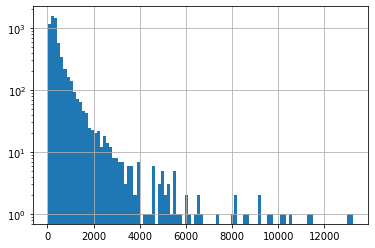

In [46]:
def remove_newlines(serie):
    serie = serie.str.replace('\n', ' ', regex=False)
    serie = serie.str.replace('\\n', ' ', regex=False)
    serie = serie.str.replace('  ',' ', regex=False)
    serie = serie.str.replace('  ',' ', regex=False)
    return serie


from transformers import GPT2TokenizerFast

df['text'] = "Topic: " + df.docs + " - " + df.category + "; Question: " + df.thread + " - " + df.question + "; Answer: " + df.context
df['text'] = remove_newlines(df.text)
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))

df.n_tokens.hist(bins=100, log=True)

<AxesSubplot:>

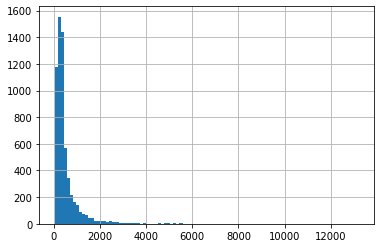

In [54]:
df.n_tokens.hist(bins=100)

In [55]:
df = df[df.n_tokens < 2000]

## Get Embeddings, and save them

In [56]:
size = 'curie'

from openai.embeddings_utils import get_embedding

df['embeddings'] = df.text.apply(lambda x: get_embedding(x, engine=f'text-search-{size}-doc-001'))
df.to_parquet('data/curie_embeddings.parquet')
df.head()

,docs,category,thread,href,question,context,marked,text,n_tokens,embeddings
0,huggingface,Beginners,Can’t download (some) models although they are...,https://discuss.huggingface.co/t/cant-download...,"Can’t download (some) models to pytorch, altho...",Looking at umarayub/t5-small-finetuned-xsum at...,0,Topic: huggingface - Beginners; Question: Can’...,550,"[0.004923707339912653, -0.016777075827121735, ..."
1,huggingface,Beginners,"Trainer.push_to_hub is taking lot of time, is ...",https://discuss.huggingface.co/t/trainer-push-...,"Hi, I’m trying to push my model to HF hub via ...",@sgugger can you please help me out with this...,0,Topic: huggingface - Beginners; Question: Trai...,204,"[0.0020476023200899363, -0.0010360622545704246..."
2,huggingface,Beginners,SSLCertVerificationError when loading a model,https://discuss.huggingface.co/t/sslcertverifi...,I am exploring potential opportunities of usin...,I’m also getting the same error. Please let me...,0,Topic: huggingface - Beginners; Question: SSLC...,494,"[0.002923486055806279, 0.007949204184114933, 0..."
3,huggingface,Beginners,How to use embeddings to compute similarity?,https://discuss.huggingface.co/t/how-to-use-em...,"Hi, I would like to compute sentence similarit...","With transformers, the feature-extraction pipe...",0,Topic: huggingface - Beginners; Question: How ...,351,"[-0.011044162325561047, 0.0021849798504263163,..."
4,huggingface,Beginners,How to use additional input features for NER?,https://discuss.huggingface.co/t/how-to-use-ad...,"Hello,\nI’ve been following the documentation ...","mhl:\n\ne.g [“Arizona_NNP”, “Ice_NNP”, “Tea_NN...",0,Topic: huggingface - Beginners; Question: How ...,1718,"[0.002879042411223054, -0.004730842541903257, ..."
